# ISW table transformation

## Import

In [40]:
import numpy as np
import pandas as pd
import re
import string
import os

import nltk

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet, stopwords

from sklearn.feature_extraction.text import TfidfTransformer as tfidf
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import pickle

from src.model_building import LemmaTokenizer


In [41]:
data_dir = os.path.join(os.getcwd(), 'models')
os.makedirs(data_dir, exist_ok=True)

nltk.data.path.append(data_dir)

nltk.download('punkt_tab', download_dir=data_dir)
nltk.download('wordnet', download_dir=data_dir)
nltk.download('stopwords', download_dir=data_dir)

[nltk_data] Downloading package punkt_tab to D:\NaUKMA\DS\H2_python_st
[nltk_data]     ructure_and_data\src\prepar_notebooks\models...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to D:\NaUKMA\DS\H2_python_stru
[nltk_data]     cture_and_data\src\prepar_notebooks\models...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to D:\NaUKMA\DS\H2_python_st
[nltk_data]     ructure_and_data\src\prepar_notebooks\models...
[nltk_data]   Package stopwords is already up-to-date!


True

# Some cleaning

In [42]:
df_raw = pd.read_csv("../../data/ISW.csv")

df_result = pd.DataFrame()

In [43]:
df_raw.head(10)

,date,content
0,2022-02-24,"Mason Clark, George Barros, and Kateryna Stepa..."
1,2022-02-25,"Mason Clark, George Barros, and Kateryna Stepa..."
2,2022-02-26,"Mason Clark, George Barros, and Katya Stepanen..."
3,2022-02-27,"Mason Clark, George Barros, and Kateryna Stepa..."
4,2022-02-28,"Mason Clark, George Barros, and Kateryna Stepa..."
5,2022-03-01,"Frederick W. Kagan, George Barros, and Kateryn..."
6,2022-03-02,"Mason Clark, George Barros, and Kateryna Stepa..."
7,2022-03-03,"Mason Clark, George Barros, and Kateryna Stepa..."
8,2022-03-04,"Fredrick W. Kagan, George Barros, and Kateryna..."
9,2022-03-05,"Fredrick W. Kagan, George Barros, and Kateryna..."


In [44]:
df_raw.dropna(inplace=True)

# Text Preprocessing

In [45]:
month_names = [
            'january', 'february', 'march', 'april', 'may', 'june',
            'july', 'august', 'september', 'october', 'november', 'december'
        ]

def clean_text(x):
    if isinstance(x, str):
        x = x.lower()
        x = re.sub(r'https?://\S+|www\.\S+', '', x)
        punctuation_to_remove = '”“–’'.join(c for c in string.punctuation)
        x = re.sub(f'[{re.escape(punctuation_to_remove)}]', '', x)
        x = re.sub(r'\b(?:' + '|'.join(month_names) + r')\s+\d{1,2}\b', '', x)
        x = re.sub(r'[©®™•·]', ' ', x)
        x = re.sub(r'\s+', ' ', x).strip()
    return x

df_raw['content'] = df_raw['content'].map(clean_text)

# Text Normalization and Feature extraction

In [63]:
lemming = CountVectorizer(lowercase=True, ngram_range=(2,2), tokenizer=LemmaTokenizer(), max_features=2000,
                         min_df=5, max_df=0.8)

X_lemma = lemming.fit_transform(df_raw['content'].fillna(''))

D:\NaUKMA\DS\H2_python_structure_and_data\venv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [64]:
with open('../our_models/3_lemming_v1.pkl', 'wb') as f:
    pickle.dump(lemming, f)

## Redundant part for Stemming

In [65]:
class StemmerTokenizer:
    def __init__(self):
        self.sp = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))
    def __call__(self, doc):
        return [self.sp.stem(t) for t in word_tokenize(doc) if t not in self.stop_words]

In [10]:
# stemming = CountVectorizer(lowercase=True, ngram_range=(1,2), tokenizer=StemmerTokenizer())
#
# X_stemming = stemming.fit_transform(df_raw['content'].fillna(''))

# We will be using Lemmatization for the tf-idf

## As for this project we are not operating with a giant dataset, we can spend more time on converting to lemmas

*However we'll still add column with both stemming and lemming*

In [66]:
df_raw['lemma_content'] = df_raw['content'].apply(lambda x: ' '.join(LemmaTokenizer()(x)) if isinstance(x, str) else '')
df_raw['stem_content'] = df_raw['content'].apply(lambda x: ' '.join(StemmerTokenizer()(x)) if isinstance(x, str) else '')

In [67]:
tf_idf = tfidf()
X_tf_idf = tf_idf.fit_transform(X_lemma)
X_dense = X_tf_idf.toarray()

In [68]:
with open('../our_models/3_tf_idf_v1.pkl', 'wb') as f:
    pickle.dump(tf_idf, f)

In [69]:
feature_names = lemming.get_feature_names_out()
pd.Series(feature_names).to_csv("../../data/features.csv", index=False, header=False)

In [70]:
feature_names

array(['1 capture', '1 kharkiv', '1 luhansk', ..., 'zaporizhzhia city',
       'zaporizhzhia nuclear', 'zelensky stated'],
      shape=(2000,), dtype=object)

array(['1 capture', '1 kharkiv', '1 luhansk', ..., 'zaporizhzhia city',
       'zaporizhzhia nuclear', 'zelensky stated'],
      shape=(2000,), dtype=object)

In [71]:
top_n = 1000

keywords_per_doc = []
for i in range(X_tf_idf.shape[0]):
    doc_vector = X_dense[i]

    top_indices = doc_vector.argsort()[-top_n:][::-1]
    top_keywords = [(feature_names[idx], doc_vector[idx]) for idx in top_indices]

    max_importance = max([score for _, score in top_keywords])
    keywords_dict = {word: float(round(score / max_importance, 3)) for word, score in top_keywords}
    keywords_per_doc.append(keywords_dict)

df_raw['keywords'] = keywords_per_doc

In [72]:
df_raw['keywords']

0       {'local time': 1.0, 'frontal assault': 0.767, ...
1       {'force entered': 1.0, 'frontal assault': 0.98...
2       {'local time': 1.0, 'force likely': 0.398, 'li...
3       {'coming day': 1.0, 'however russian': 0.974, ...
4       {'russian operation': 1.0, 'northeastern ukrai...
                              ...                        
1099    {'order battle': 1.0, 'unconfirmed russianclai...
1100    {'order battle': 1.0, 'battle element': 0.715,...
1101    {'united state': 1.0, 'unconfirmed russianclai...
1102    {'attacking near': 1.0, 'force attacked': 0.98...
1103    {'order battle': 1.0, 'motorized rifle': 0.798...
Name: keywords, Length: 1084, dtype: object

In [73]:
df_raw['keywords'] = df_raw['keywords'].apply(lambda x: dict(sorted(x.items())))

In [74]:
def replace_with_numbers(dictionary):

    return " ".join(str(i) for i in dictionary.values())

df_raw['keywords'] = df_raw['keywords'].apply(replace_with_numbers)

0       (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
1       (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
2       (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
3       (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
4       (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
                              ...                        
1099    (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
1100    (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
1101    (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
1102    (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
1103    (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
Name: keywords, Length: 1084, dtype: object

0       0.0 0.0 0.0 0.0 0.0 0.0 0.507 0.0 0.0 0.0 0.32...
1       0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0....
2       0.0 0.0 0.0 0.0 0.0 0.0 0.135 0.0 0.0 0.0 0.51...
3       0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.339 ...
4       0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.871 ...
                              ...                        
1099    0.0 0.067 0.0 0.0 0.0 0.0 0.067 0.043 0.0 0.0 ...
1100    0.0 0.067 0.0 0.0 0.0 0.0 0.0 0.043 0.0 0.0 0....
1101    0.0 0.057 0.0 0.0 0.0 0.049 0.0 0.037 0.0 0.0 ...
1102    0.0 0.051 0.0 0.0 0.0 0.0 0.052 0.033 0.0 0.0 ...
1103    0.0 0.067 0.0 0.0 0.0 0.058 0.0 0.043 0.0 0.0 ...
Name: keywords, Length: 1084, dtype: object

0       (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
1       (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
2       (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
3       (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
4       (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
                              ...                        
1099    (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
1100    (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
1101    (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
1102    (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
1103    (1 capture, 1 kharkiv, 1 luhansk, 10km south, ...
Name: keywords, Length: 1084, dtype: object

0       0.233 0.149 0.107 0.14 0.258 0.194 0.141 0.07 ...
1       0.954 0.725 0.292 0.481 0.267 0.414 0.229 0.44...
2       0.054 0.064 0.206 0.049 0.054 0.032 0.114 0.08...
3       0.331 0.184 0.398 0.255 0.502 0.333 0.347 0.12...
4       0.871 0.242 0.336 0.362 0.255 0.333 0.439 0.41...
                              ...                        
1099    0.067 0.067 0.077 0.067 0.043 0.068 0.083 0.09...
1100    0.067 0.067 0.178 0.088 0.087 0.043 0.068 0.06...
1101    0.057 0.058 0.151 0.049 0.037 0.058 0.073 0.07...
1102    0.051 0.051 0.197 0.113 0.051 0.033 0.051 0.06...
1103    0.067 0.067 0.087 0.149 0.058 0.043 0.068 0.08...
Name: keywords, Length: 1084, dtype: object

# Dimensionality Reduction
## In the graphic bellow we see that optimal amount of components is 400

In [30]:
pca = PCA(n_components=400, whiten=True, random_state=69)
X_pca = pca.fit_transform(X_dense)

In [31]:
with open('../our_models/3_PCA_v1.pkl', 'wb') as f:
    pickle.dump(pca, f)

Cumulative explained variance ratio:
Components 1: 0.084
Components 2: 0.132
Components 3: 0.160
Components 4: 0.186
Components 5: 0.207
Components 6: 0.220
Components 7: 0.234
Components 8: 0.245
Components 9: 0.255
Components 10: 0.264
Components 11: 0.272
Components 12: 0.279
Components 13: 0.286
Components 14: 0.293
Components 15: 0.299
Components 16: 0.305
Components 17: 0.311
Components 18: 0.317
Components 19: 0.322
Components 20: 0.327
Components 21: 0.332
Components 22: 0.337
Components 23: 0.342
Components 24: 0.346
Components 25: 0.351
Components 26: 0.355
Components 27: 0.359
Components 28: 0.363
Components 29: 0.367
Components 30: 0.371
Components 31: 0.375
Components 32: 0.378
Components 33: 0.382
Components 34: 0.386
Components 35: 0.389
Components 36: 0.393
Components 37: 0.396
Components 38: 0.400
Components 39: 0.403
Components 40: 0.406
Components 41: 0.410
Components 42: 0.413
Components 43: 0.416
Components 44: 0.419
Components 45: 0.422
Components 46: 0.425
Compon

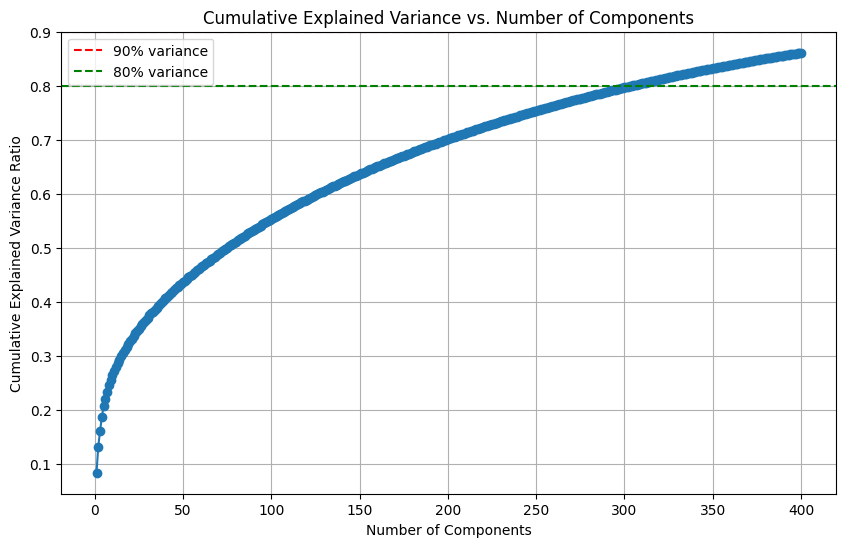

In [32]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

print("Cumulative explained variance ratio:")
for i, variance in enumerate(cumulative_variance_ratio):
    print(f"Components {i+1}: {variance:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% variance')
plt.axhline(y=0.8, color='g', linestyle='--', label='80% variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()
plt.show()

In [33]:
feature_names = lemming.get_feature_names_out()

In [34]:
top_n = 1000

keywords_per_doc = []
for i in range(X_pca.shape[0]):
    doc_vector = X_pca[i]
    feature_importance = np.zeros(len(feature_names))

    for i, weight in enumerate(doc_vector):
        feature_importance += abs(weight) * abs(pca.components_[i])

    top_indices = feature_importance.argsort()[-top_n:][::-1]
    top_keywords = [(feature_names[idx], feature_importance[idx] ) for idx in top_indices]

    max_importance = max([score for _, score in top_keywords])
    keywords_dict = {word: float(round(score / max_importance, 3)) for word, score in top_keywords}
    keywords_per_doc.append(keywords_dict)

df_raw['keywords'] = keywords_per_doc

In [35]:
df_raw['keywords'] = df_raw['keywords'].apply(lambda x: dict(sorted(x.items())))
def replace_with_numbers(dictionary):

    return " ".join(str(i) for i in dictionary.values())

df_raw['keywords'] = df_raw['keywords'].apply(replace_with_numbers)

In [36]:
df_raw.head(6)

,date,content,lemma_content,stem_content,keywords
0,2022-02-24,mason clark george barros and kateryna stepane...,mason clark george barros kateryna stepanenko ...,mason clark georg barro kateryna stepanenko 30...,0.447 0.458 0.753 0.629 0.416 0.465 0.464 0.42...
1,2022-02-25,mason clark george barros and kateryna stepane...,mason clark george barros kateryna stepanenko ...,mason clark georg barro kateryna stepanenko 30...,0.479 0.504 0.756 0.694 0.492 0.494 0.47 0.533...
2,2022-02-26,mason clark george barros and katya stepanenko...,mason clark george barros katya stepanenko 3pm...,mason clark georg barro katya stepanenko 3pm e...,0.373 0.429 0.728 0.361 0.504 0.352 0.379 0.40...
3,2022-02-27,mason clark george barros and kateryna stepane...,mason clark george barros kateryna stepanenko ...,mason clark georg barro kateryna stepanenko 4p...,0.457 0.498 0.441 0.806 0.437 0.655 0.471 0.51...
4,2022-02-28,mason clark george barros and kateryna stepane...,mason clark george barros kateryna stepanenko ...,mason clark georg barro kateryna stepanenko 33...,0.462 0.453 0.743 0.439 0.711 0.436 0.487 0.45...
5,2022-03-01,frederick w kagan george barros and kateryna s...,frederick w kagan george barros kateryna stepa...,frederick w kagan georg barro kateryna stepane...,0.466 0.5 0.933 0.448 0.641 0.454 0.488 0.458 ...


In [75]:
df_result = df_raw

df_result.to_csv("../../data/ISW_vector_tfidf.csv", index=False)